# RVI Implementation for Infinite-Horizon, Undiscounted, Average-Reward MDP

This implementation is for finding an optimal policy for an ambulance dispatching problem on a grid-world. An infinite-horizon, undiscounted, average reward MDP model is defined. An optimal policy and relative state values have been achieved at the end of the implementation.

## Setup

### Libraries & Helper Class

In [1]:
from collections import defaultdict # this is a useful data structure for storing the transition probabilities and rewards for each state

import numpy as np
np.random.seed(30)

import math
import random

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# show gridworld_visual picture which in the path /content/drive/MyDrive/Average Reward MDP Policy Optimization/gridworld_visual.png
# from IPython.display import Image
# Image(filename='/content/drive/MyDrive/Average Reward MDP Policy Optimization/gridworld_visual.png', width=300)

In [3]:
from typing import Tuple

class GridHelper:
    def __init__(self, n: int):
        self.n: int = n

    def coord_to_index(self, x: int, y: int) -> int:
        return x * self.n + y

    def index_to_coord(self, index: int) -> Tuple[int, int]:
        return divmod(index, self.n)

    def manhattan_distance(self, a: int, b: int) -> int:
        ax, ay = self.index_to_coord(a)
        bx, by = self.index_to_coord(b)
        return abs(ax - bx) + abs(ay - by)

### States and Helpers

In [4]:
n = 5 # Size of the grid

first_ambulance_index = 0
last_ambulance_index = n**2 - 1

#states = [(a1, a2) for a1 in range(0, n**2 - 1) for a2 in range(0, n**2 - 1) if a1 != a2]
states = [(a1, a2) for a1 in range(0, n**2 - 1) for a2 in range(0, n**2 - 1)]
#states.append((0, 0))

In [5]:
print("Total number of states:", len(states))

Total number of states: 576


In [6]:
# we need to map states to indices for easier access
state2idx = {s: k for k, s in enumerate(states)}

In [7]:
grid_helper = GridHelper(n)

### Parameters

#### Service Time and Arrival Rate

In [8]:
# define an np array to hold the expected service time for each patient location and ambulance spot
expected_service_time = np.zeros((n**2, 2))  # in hours
for j in range(0, 2):
    for i in range(n**2):
        if j == 0:
            man_distance = grid_helper.manhattan_distance(i, 0)
        else:
            man_distance = grid_helper.manhattan_distance(i, n**2 - 1)
        expected_service_time[i, j] = np.random.normal(man_distance*4,1,1)/60 #here we are just generating numbers by using normal dist.

# edge cases. We won't use these pairs in the implementation
expected_service_time[0,0] = 0
expected_service_time[0,1] = 0
expected_service_time[n**2-1,0] = 0
expected_service_time[n**2-1,1] = 0

In [9]:
expected_service_time*60 # in minutes

array([[ 0.        ,  0.        ],
       [ 5.52790535, 29.42550989],
       [ 7.02928906, 23.33524488],
       [12.47055962, 20.98501786],
       [15.89930328, 14.29953473],
       [ 4.30379318, 26.89985619],
       [ 6.27403757, 22.68435591],
       [13.58509537, 20.81050091],
       [16.13429659, 14.95522163],
       [18.89314453, 11.31077063],
       [ 9.57822555, 23.14724314],
       [12.10749794, 21.11347211],
       [15.23595217, 14.07883028],
       [19.22481149, 11.29859758],
       [25.38384717,  8.84908785],
       [12.76038508, 21.05069979],
       [15.71435449, 15.46312554],
       [20.53836748, 11.97080728],
       [21.91610337,  9.39405598],
       [28.93778171,  3.60213256],
       [15.994222  , 17.01912738],
       [19.53252103, 13.8988813 ],
       [23.5769847 ,  7.64515036],
       [29.06448209,  3.61298353],
       [ 0.        ,  0.        ]])

In [10]:
# probability of the service less than 10 minutes
coverage_reward_prob_high = np.empty_like(expected_service_time)
for i in range(expected_service_time.shape[0]):
    for j in range(expected_service_time.shape[1]):
        if expected_service_time[i, j] > 0:
            coverage_reward_prob_high[i, j] = 1 - math.exp(-(1/expected_service_time[i, j]) * 1/6)
        else:
            coverage_reward_prob_high[i, j] = 0  # or np.nan if you prefer
coverage_reward_prob_high

array([[0.        , 0.        ],
       [0.8361827 , 0.28811662],
       [0.7589182 , 0.34853807],
       [0.55151885, 0.37906598],
       [0.46685315, 0.50307862],
       [0.90207288, 0.31047285],
       [0.79686205, 0.35649948],
       [0.52102211, 0.3815424 ],
       [0.46194673, 0.4876067 ],
       [0.41097845, 0.58691961],
       [0.64796853, 0.35080159],
       [0.56217434, 0.37726315],
       [0.48125472, 0.50849653],
       [0.40557525, 0.5873129 ],
       [0.32561311, 0.67698612],
       [0.54327573, 0.37814205],
       [0.47078518, 0.47622852],
       [0.38546759, 0.56628409],
       [0.36636709, 0.65510074],
       [0.2921825 , 0.93772114],
       [0.46485941, 0.44432639],
       [0.40068424, 0.51299572],
       [0.34566933, 0.72964483],
       [0.29111542, 0.93719971],
       [0.        , 0.        ]])

In [ ]:
coverage_reward_prob_low = coverage_reward_prob_high/100 #highly low reward for low priority patients

In [12]:
# define an array with size 3 to keep the rewards for each ambulance, cell, and priority level
# coverage_reward[patient_index, ambulance_index, priority_level]
coverage_reward = np.zeros((n**2, 2, 2)) 

coverage_reward[:, 0, 0] = coverage_reward_prob_low[:, 0]  # all patients, first ambulance, low priority
coverage_reward[:, 0, 1] = coverage_reward_prob_high[:, 0] # all patients, first ambulance, high priority

coverage_reward[:, 1, 0] = coverage_reward_prob_low[:, 1] # all patients, second ambulance, low priority
coverage_reward[:, 1, 1] = coverage_reward_prob_high[:, 1] # all patients, second ambulance, high priority

In [13]:
arr_rate = 0.5         # arrivals per hour

#### Probability of a Request from the Cells

In [14]:
P = np.zeros(n**2) # arrival-location pmf
for i in range(n**2):
    # The first and last indices are the hospitals, so we set their probabilities to 0.
    # This means that the ambulance will never be dispatched to these locations.
    if i == 0 or i == n**2 - 1:
        P[i] = 0.0
    else:
        P[i] = np.random.uniform(0, 1)
P /= np.sum(P)
# round to 2 decimal points
P = np.round(P, 4)

In [15]:
P

array([0.    , 0.0652, 0.0544, 0.0258, 0.0459, 0.0503, 0.0474, 0.011 ,
       0.0491, 0.0392, 0.0114, 0.0025, 0.0747, 0.0204, 0.0045, 0.0308,
       0.0284, 0.0784, 0.0747, 0.0463, 0.079 , 0.0787, 0.0688, 0.0129,
       0.    ])

In [16]:
print(np.sum(P))  # should be 1.0

0.9998


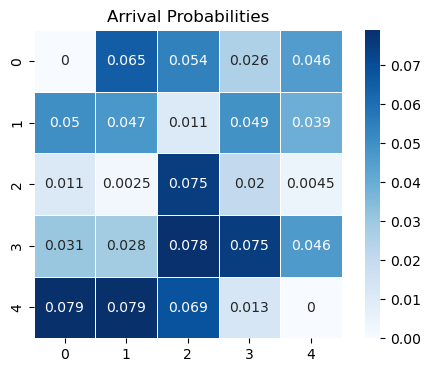

In [17]:
# heatmap representation of the arrival probabilities
plt.figure(figsize=(6, 4))
sns.heatmap(P.reshape(n, n), annot=True, cmap='Blues', square=True, linewidths=0.5)  
plt.title('Arrival Probabilities')
plt.xticks(ticks=np.arange(n) + 0.5, labels=np.arange(n))
plt.yticks(ticks=np.arange(n) + 0.5, labels=np.arange(n))
plt.grid(False)
plt.show()

#### Conditional Probability Values for High and Low Priority Patients

In [18]:
def assign_probabilities(size: int, low_range=(0.35, 0.60),  high_range=(0.50, 0.75)):
    
    probs = np.zeros((size, size), dtype=float)
    max_idx = size - 1

    for r in range(size):
        for c in range(size):
            # Skip the two corner cells – they stay at 0.
            if (r == 0 and c == 0) or (r == max_idx and c == max_idx):
                continue
            
            d_ul = r + c                          # distance to (0, 0)
            d_lr = (max_idx - r) + (max_idx - c)  # distance to (max_idx, max_idx)

            if d_ul < d_lr:                       # closer to upper-left
                probs[r, c] = random.uniform(*high_range)
            else:                                 # closer to lower-right
                probs[r, c] = random.uniform(*low_range)
    return probs


In [19]:
P_low = assign_probabilities(n)  # deterministic run
P_high = np.zeros(n**2)
P_high = 1 - P_low
P_high[0, 0] = 0.0  # hospital at (0, 0) has no probability
P_high[-1, -1] = 0.0  # hospital at (n

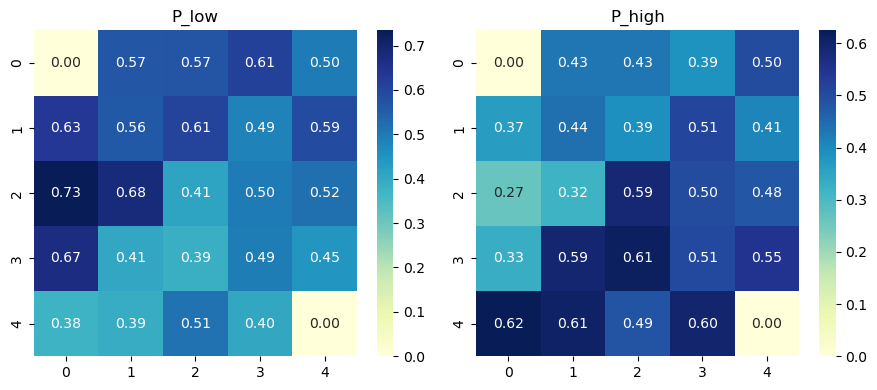

In [20]:
# show P_low and P_high heatmaps side by side
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
sns.heatmap(P_low.reshape(n, n),  annot=True, fmt=".2f", ax=axes[0], cmap="YlGnBu")
axes[0].set_title("P_low")  
sns.heatmap(P_high.reshape(n, n), annot=True, fmt=".2f", ax=axes[1], cmap="YlGnBu")
axes[1].set_title("P_high")
plt.tight_layout()
plt.show()

In [21]:
# combine P_low and P_high into two-dimensional array
P_pri_combined = np.zeros((2, n**2))
# assign P_low to first row and P_high to second row
P_pri_combined[0, :] = P_low.flatten()
P_pri_combined[1, :] = P_high.flatten()

### Actions

In [22]:
def actions(s,i,j):
    if s[0]==0 and s[1]==0:
        return [0,1]
    elif s[0]==0 and s[1]>0:
        return [0]
    elif s[0]>0 and s[1]==0:
        return [1]
    else:
        return None

### Alternative Policies

In [23]:
def only_zero(s,i,j):
    alternative_actions = actions(s,i,j)
    if alternative_actions == [0,1]:
        return [0]
    else:
        return alternative_actions

def only_one(s,i,j):
    alternative_actions = actions(s,i,j)
    if alternative_actions == [0,1]:
        return [1]
    else:
        return alternative_actions
    
def random_select(s,i,j):
    np.random.seed(i)
    alternative_actions = actions(s,i,j)
    if alternative_actions == [0,1]:
        return [int(np.random.choice([0,1]))]
    else:
        return alternative_actions
    
def closest(s,i,j):
    alternative_actions = actions(s,i,j)
    if alternative_actions == [0,1]:
        dist_to_0 = grid_helper.manhattan_distance(i,0)
        dist_to_1 = grid_helper.manhattan_distance(i,n**2-1)
        if dist_to_0<dist_to_1:
            return [0]
        else:
            return [1]
    else:
        return alternative_actions

### Event Rates

In [24]:
# probability of the service less than 10 minutes
inversed_expected_service_time = np.empty_like(expected_service_time)
for i in range(expected_service_time.shape[0]):
    for j in range(expected_service_time.shape[1]):
        if expected_service_time[i, j] > 0:
            inversed_expected_service_time[i, j] = 1/expected_service_time[i, j]
        else:
            inversed_expected_service_time[i, j] = 0  # or np.nan 
inversed_expected_service_time

array([[ 0.        ,  0.        ],
       [10.85402086,  2.03904708],
       [ 8.53571385,  2.57121793],
       [ 4.8113318 ,  2.8591827 ],
       [ 3.77375027,  4.19594072],
       [13.94119035,  2.2304952 ],
       [ 9.56321975,  2.64499465],
       [ 4.41660499,  2.88315982],
       [ 3.71878623,  4.01197665],
       [ 3.17575509,  5.30467834],
       [ 6.2642083 ,  2.59210134],
       [ 4.95560687,  2.84178745],
       [ 3.93805384,  4.26171769],
       [ 3.12096688,  5.31039357],
       [ 2.3637079 ,  6.78035985],
       [ 4.70205245,  2.85026154],
       [ 3.81816511,  3.88019872],
       [ 2.92136169,  5.0121933 ],
       [ 2.73771295,  6.3870175 ],
       [ 2.07341394, 16.65679956],
       [ 3.75135471,  3.52544514],
       [ 3.0718001 ,  4.31689419],
       [ 2.54485469,  7.84811249],
       [ 2.06437534, 16.60677374],
       [ 0.        ,  0.        ]])

In [25]:
mu_max_0 = np.max(inversed_expected_service_time[:,0])
mu_max_1 = np.max(inversed_expected_service_time[:,1])

print("Maximum service time for ambulance 0:", mu_max_0)
print("Maximum service time for ambulance 1:", mu_max_1)

Maximum service time for ambulance 0: 13.941190346445088
Maximum service time for ambulance 1: 16.656799556970213


In [26]:
# this is needed for the normalization procedure. Here normalization is a process of transforming a continuous 
# Markov Decision Process (MDP) into a discrete one by scaling transition probabilities.
gamma = arr_rate + (mu_max_0 + mu_max_1)
gamma

31.097989903415304

## Transitions

In [27]:
def transitions_service_completion(s):
    grid_size = n
    state_info = defaultdict(lambda: {"reward": 0.0, "prob": 0.0})

    # --- 1. Service completions ------------------------------------------
    for p_idx, provider_cell in enumerate((0, 1)): # to understand these, you need to remember the state representation which is a
        # tuple of two indices representing the ambulances' positions or 0 if the ambulance is idle. Also we have two ambulances which are
        # represented by indices 0 and 1.
        job = s[p_idx]
        if job != 0:
            rate   = inversed_expected_service_time[job, provider_cell]
            prob   = rate / gamma
            s_next = list(s)                # copy current state
            s_next[p_idx] = 0               # provider becomes idle
            state_info[tuple(s_next)]["reward"] += 0.0
            state_info[tuple(s_next)]["prob"]   += prob
            
    return state_info

In [28]:
def transitions_busy(s,state_info):
    
    grid_size = n

    # --- 2. Customer arrival ---------------------------------------------
    prob_arr = arr_rate / gamma
    for i in range(grid_size**2):
        for j in range(2): # this is for two priorities (low(0) and high(1))
            if P[i] == 0:               # skip provider cells
                continue
            s_next = s             # state unchanged
            state_info[s_next]["reward"] += 0.0
            state_info[s_next]["prob"]   += prob_arr * P[i] * P_pri_combined[j, i]

    return state_info

In [29]:
def transitions_available(s,i,j,V,state_info,actions):
    grid_size = n
    prob_arr = arr_rate / gamma

    available_actions = actions(s,i,j)
    prob_arr = arr_rate / gamma

    event_probability = prob_arr * P[i] * P_pri_combined[j, i]

    best_action_value = -np.inf
    best_action = None

    if available_actions == None:
        state_info[tuple(s)]["prob"]   += event_probability
        return state_info, None
    
    for a in available_actions:
        s_next = list(s)
        s_next[a] = i

        val = coverage_reward[i,a,j] + event_probability*V[state2idx[tuple(s_next)]]
        if val>best_action_value:
            best_action_value = val
            best_action = a

    s_next = list(s)
    s_next[best_action] = i

    state_info[tuple(s_next)]["reward"] += coverage_reward[i, best_action, j]
    state_info[tuple(s_next)]["prob"]   += prob_arr * P[i] * P_pri_combined[j, i]

    return state_info, best_action

In [30]:
def transition_remaining(s, state_info):
    total_prob = sum(s["prob"] for s in state_info.values())

    residual_prob = 1.0 - total_prob

    state_info[s]["reward"] += 0.0
    state_info[s]["prob"] += residual_prob

    return state_info

## Relative Value Iteration

In [31]:
def rvi(eps=1e-12, max_iter=10000, benchmark = None):
    V = np.zeros(len(states))
    # best action value for each state
    
    g = 0.0                             # bias estimate
    ref = 0                            # choose arbitrary reference state. ! this was changed
    
    actions_ = actions
    if benchmark:
        actions_ = benchmark

    optimal_policy = np.zeros((2,n**2))
    optimal_policy[0] = -1
    optimal_policy[-1] = -1
    for it in range(max_iter):
        V_new = np.empty_like(V) # this will create a new array with the same shape and dtype as V but its contents are uninitialized
        g_num = 0.0
        V_old = np.copy(V_new)

        for k, s in enumerate(states):
            
            state_info = transitions_service_completion(s)

            if s[0]>0 and s[1]>0:
                state_info = transitions_busy(s,state_info=state_info)
            
            else:
                for i in range(n**2):
                    if P[i] == 0:               # skip provider cells
                        continue
                    for j in range(2):
                        state_info,best_action = transitions_available(s,i,j,V,state_info,actions_)
                        if s == (0,0):
                            optimal_policy[j,i] = best_action

            state_info = transition_remaining(s, state_info)

            q = 0
            for ns, p, r in [(ns, info["prob"], info["reward"]) for ns, info in state_info.items()]:
                q += p * (r + V[state2idx[ns]])
              
            V_new[k] = q

        #g_new = g_num / len(states)      # average over states
        g_new = V_new[ref]-V_old[ref]
        #g_new= min(V_new)    
        V_new -= V_new[ref]             # anchor
        #V_new -= min(V_new)              # here we are choosing the state with minimum value as the reference one.
        
        if it % 100 == 0:
            print(f"Iteration {it}, g = {g:.4f}, max |V_new - V| = {np.max(np.abs(V_new - V)):.10f}")
            
        if np.max(np.abs(V_new - V)) < eps:
            return g_new, V_new, optimal_policy

        V, g = V_new, g_new

    raise RuntimeError("RVI failed to converge")

Iteration 0, g = 0.0000, max |V_new - V| = 0.0103466398
Iteration 100, g = 0.0101, max |V_new - V| = 0.0000070709
Iteration 200, g = 0.0101, max |V_new - V| = 0.0000000088
Iteration 300, g = 0.0101, max |V_new - V| = 0.0000000000


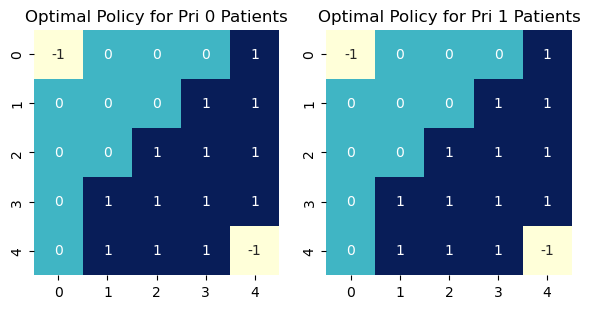

In [39]:
# Optimal
final_average_reward_optimal, V, optimal_policy = rvi()

# visualize best_action_grid_pri_0 and best_action_grid_pri_1 on a heatmap and plot them side by side
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
sns.heatmap(optimal_policy[0].reshape(n,n), annot=True, fmt=".0f", ax=axes[0], cmap="YlGnBu", cbar=False, square=True)
axes[0].set_title("Optimal Policy for Pri 0 Patients")  
sns.heatmap(optimal_policy[1].reshape(n,n), annot=True, fmt=".0f", ax=axes[1], cmap="YlGnBu", cbar=False, square=True)
axes[1].set_title("Optimal Policy for Pri 1 Patients")
plt.tight_layout()
plt.show()  

Iteration 0, g = 0.0000, max |V_new - V| = 0.0103202984
Iteration 100, g = 0.0101, max |V_new - V| = 0.0000069868
Iteration 200, g = 0.0101, max |V_new - V| = 0.0000000087
Iteration 300, g = 0.0101, max |V_new - V| = 0.0000000000


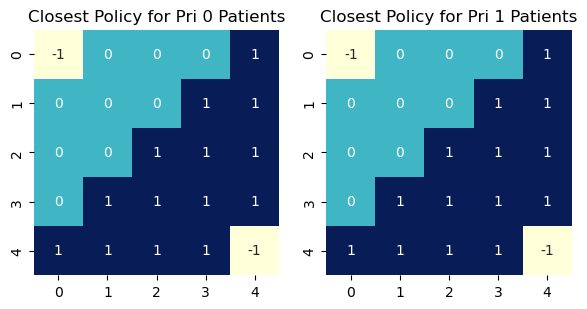

In [40]:
# Closest
final_average_reward_closest, V, closest_policy = rvi(benchmark=closest)

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
sns.heatmap(closest_policy[0].reshape(n,n), annot=True, fmt=".0f", ax=axes[0], cmap="YlGnBu", cbar=False, square=True)
axes[0].set_title("Closest Policy for Pri 0 Patients")  
sns.heatmap(closest_policy[1].reshape(n,n), annot=True, fmt=".0f", ax=axes[1], cmap="YlGnBu", cbar=False, square=True)
axes[1].set_title("Closest Policy for Pri 1 Patients")
plt.tight_layout()
plt.show()  

Iteration 0, g = 0.0000, max |V_new - V| = 0.0086198950
Iteration 100, g = 0.0085, max |V_new - V| = 0.0000024850
Iteration 200, g = 0.0085, max |V_new - V| = 0.0000000026
Iteration 300, g = 0.0085, max |V_new - V| = 0.0000000000


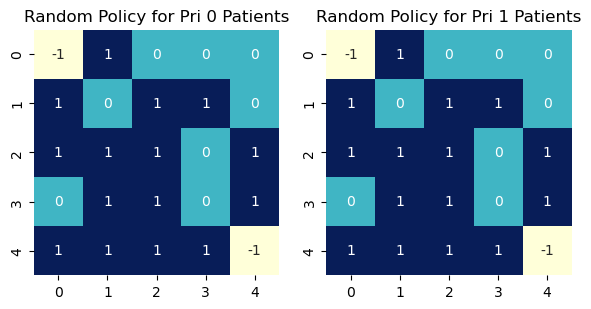

In [41]:
# Random
final_average_reward_random, V, random_policy = rvi(benchmark=random_select)

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
sns.heatmap(random_policy[0].reshape(n,n), annot=True, fmt=".0f", ax=axes[0], cmap="YlGnBu", cbar=False, square=True)
axes[0].set_title("Random Policy for Pri 0 Patients")  
sns.heatmap(random_policy[1].reshape(n,n), annot=True, fmt=".0f", ax=axes[1], cmap="YlGnBu", cbar=False, square=True)
axes[1].set_title("Random Policy for Pri 1 Patients")
plt.tight_layout()
plt.show()  

Iteration 0, g = 0.0000, max |V_new - V| = 0.0082920582
Iteration 100, g = 0.0082, max |V_new - V| = 0.0000018563
Iteration 200, g = 0.0082, max |V_new - V| = 0.0000000020
Iteration 300, g = 0.0082, max |V_new - V| = 0.0000000000


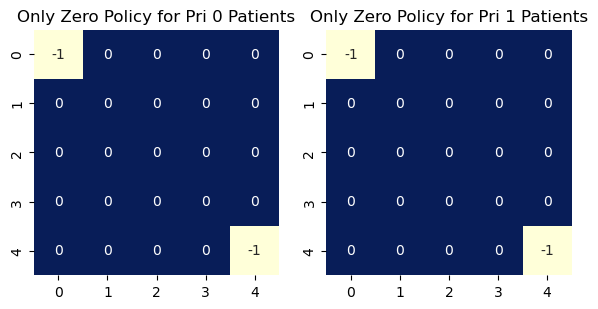

In [42]:
# Only Zero
final_average_reward_only_zero, V, only_zero_policy = rvi(benchmark=only_zero)

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
sns.heatmap(only_zero_policy[0].reshape(n,n), annot=True, fmt=".0f", ax=axes[0], cmap="YlGnBu", cbar=False, square=True)
axes[0].set_title("Only Zero Policy for Pri 0 Patients")  
sns.heatmap(only_zero_policy[1].reshape(n,n), annot=True, fmt=".0f", ax=axes[1], cmap="YlGnBu", cbar=False, square=True)
axes[1].set_title("Only Zero Policy for Pri 1 Patients")
plt.tight_layout()
plt.show()  

Iteration 0, g = 0.0000, max |V_new - V| = 0.0083130143
Iteration 100, g = 0.0082, max |V_new - V| = 0.0000018576
Iteration 200, g = 0.0082, max |V_new - V| = 0.0000000020
Iteration 300, g = 0.0082, max |V_new - V| = 0.0000000000


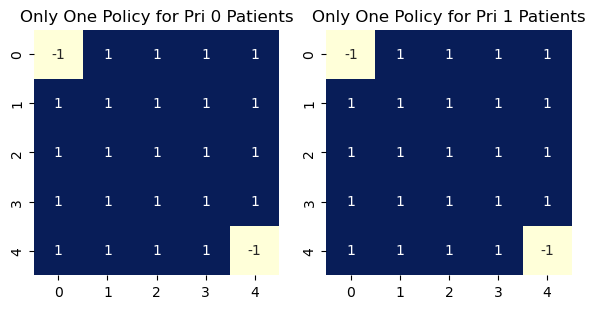

In [43]:
# Only One
final_average_reward_only_one, V, only_one_policy = rvi(benchmark=only_one)

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
sns.heatmap(only_one_policy[0].reshape(n,n), annot=True, fmt=".0f", ax=axes[0], cmap="YlGnBu", cbar=False, square=True)
axes[0].set_title("Only One Policy for Pri 0 Patients")  
sns.heatmap(only_one_policy[1].reshape(n,n), annot=True, fmt=".0f", ax=axes[1], cmap="YlGnBu", cbar=False, square=True)
axes[1].set_title("Only One Policy for Pri 1 Patients")
plt.tight_layout()
plt.show()  

### Comparison of Rewards

In [37]:
print('Optimal Average Reward: ', final_average_reward_optimal)
print('Closest Policy Average Reward: ', final_average_reward_closest)
print('Random Policy Average Reward: ', final_average_reward_random)
print('Only One Policy Average Reward: ', final_average_reward_only_one)
print('Only Zero Policy Average Reward: ', final_average_reward_only_zero)

Optimal Average Reward:  0.010131269157039862
Closest Policy Average Reward:  0.010105366764096511
Random Policy Average Reward:  0.00852193263465696
Only One Policy Average Reward:  0.008247376097095945
Only Zero Policy Average Reward:  0.008230290892977525


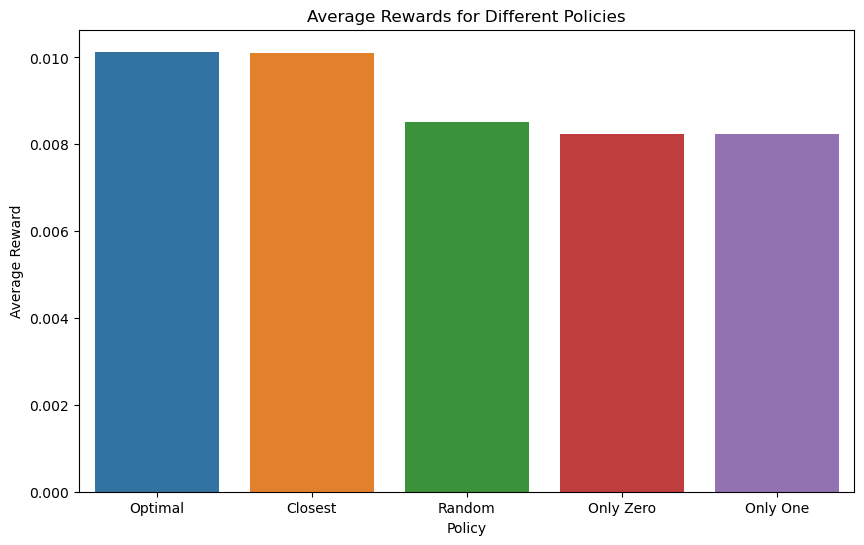

In [ ]:
# create a bar chart and visualize the results.
plt.figure(figsize=(10,6))
sns.barplot(x=["Optimal", "Closest", "Random", "Only Zero", "Only One"], y=[final_average_reward_optimal, final_average_reward_closest, final_average_reward_random, final_average_reward_only_zero, final_average_reward_only_one])
plt.title("Average Rewards for Different Policies")
plt.ylabel("Average Reward")
plt.xlabel("Policy")
plt.show()

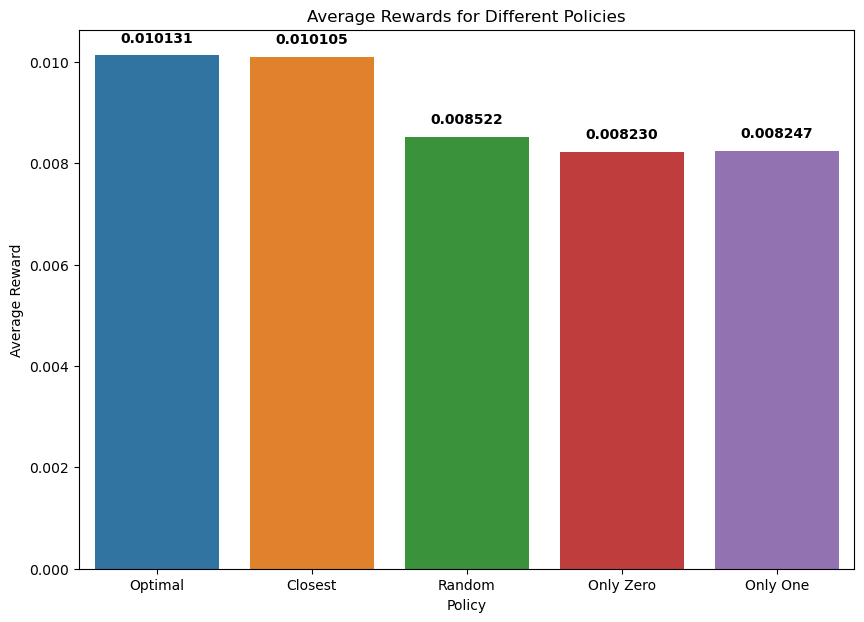

In [47]:
# create a bar chart and visualize the results. Write values on the bars
plt.figure(figsize=(10,7))
policies = ["Optimal", "Closest", "Random", "Only Zero", "Only One"]
rewards = [final_average_reward_optimal, final_average_reward_closest, final_average_reward_random, final_average_reward_only_zero, final_average_reward_only_one]
ax = sns.barplot(x=policies, y=rewards)
plt.title("Average Rewards for Different Policies")
plt.ylabel("Average Reward")
plt.xlabel("Policy")

# Add values on each bar
for i, v in enumerate(rewards):
    ax.text(i, v + 0.0002, f"{v:.6f}", ha='center', va='bottom', fontweight='bold')

plt.show()